In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive
cityscapes_data  UNet-Colorizer.h5


Import libraries

In [ ]:
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2
from glob import glob
import tensorflow as tf

# Data
from keras.preprocessing.image import img_to_array, array_to_img

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
base = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive"

In [ ]:
train_dir = os.path.join(base,'cityscapes_data/train')
test_dir = os.path.join(base, 'cityscapes_data/val')

Examining dataset

In [ ]:
# Get the number of files in the training directory
num_train_files = len(os.listdir(train_dir))
print("Total number of files in the training directory:", num_train_files)

# Get the number of files in the test directory
num_test_files = len(os.listdir(test_dir))
print("Total number of files in the test directory:", num_test_files)

Total number of files in the training directory: 2975
Total number of files in the test directory: 500


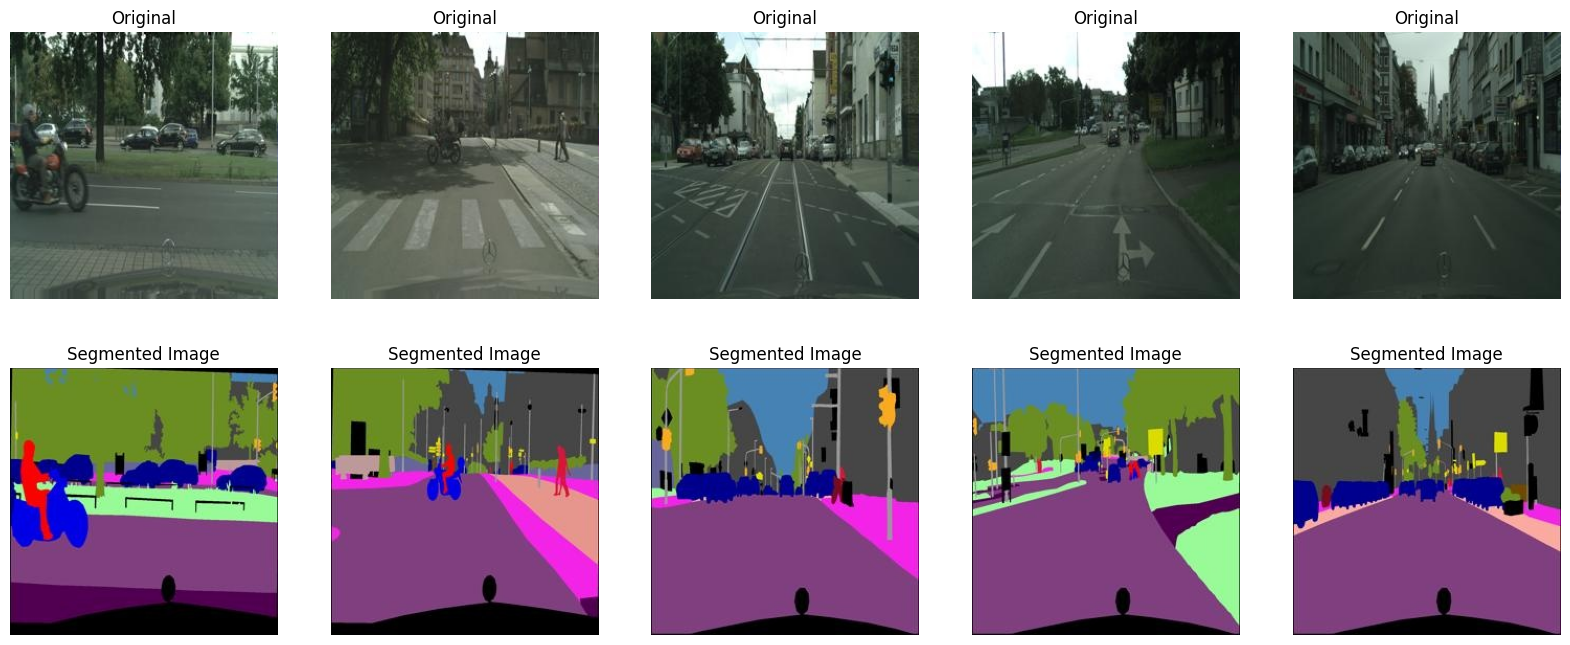

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a list of all image file paths in the train_dir
image_files = glob(os.path.join(train_dir, '*.jpg'))

# Select 5 random images
random_images = random.sample(image_files, 5)

# Display the selected images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    original_img, segmented_img = np.hsplit(img, 2)  # Split the image into two halves

    # Show the original image
    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    # Show the segmented image
    axes[1, i].imshow(segmented_img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Segmented Image')

plt.show()

Import libraries

Data Augmentation

In the case of this dataset and the problem that is being tackled it has been decided to not do data augmentation since it could interfere with the pixelwise or pixel level classification of each of the images with the intent of having a proper segmentation of the different classes.

# Preprocessing

- Resizing Images and Masks
Resizing the images and masks to a consistent size
- Color Conversion:
The color space of the images is converted from BGR (OpenCV default) to RGB using cv.cvtColor(image, cv.COLOR_BGR2RGB).
- Normalization:
The pixel values of the images and masks are normalized by dividing by 255.0.
- Data Splitting:
The code splits each image into two parts: the left half for the image and the right half for the mask.This is done because in this particular dataset the left side of the image corresponds to the original photo and the right portion of the image corresponds to the segmentation mask.

In [ ]:
# Set the desired size of your images and masks
SIZE = 192

# Set the paths for saving images and masks
image_save_path = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/images"
mask_save_path = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/masks"

# Create the directories if they don't exist
os.makedirs(image_save_path, exist_ok=True)
os.makedirs(mask_save_path, exist_ok=True)

# Initialize empty lists to store images and masks
images = []
masks = []

for i in tqdm(range(len(image_files))):
    path = image_files[i]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')

    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))

    # Convert the TensorFlow tensors to NumPy arrays
    img_np = img.numpy()
    mask_np = mask.numpy()

    # Append the resized image and mask to the lists
    images.append(img_np)
    masks.append(mask_np)

# Split the data into training and validation sets
X_train = images[:2900]
y_train = masks[:2900]

X_valid = images[2900:]
y_valid = masks[2900:]

100%|██████████| 2975/2975 [02:45<00:00, 17.98it/s]


# Working with the model


Define the model


In [ ]:
# Encoder Layer Block
class EncoderLayerBlock(Layer):
  def __init__(self, filters, rate, pooling=True):
    super(EncoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.pooling = pooling

    self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.drop = Dropout(self.rate)
    self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.pool = MaxPool2D(pool_size=(2,2))

  def call(self, X):
    x = self.c1(X)
    x = self.drop(x)
    x = self.c2(x)
    if self.pooling:
      y = self.pool(x)
      return y, x
    else:
      return x

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
        "pooling":self.pooling
    }

#  Decoder Layer
class DecoderLayerBlock(Layer):
  def __init__(self, filters, rate, padding='same'):
    super(DecoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
    self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

  def call(self, X):
    X, skip_X = X
    x = self.cT(X)
    c1 = concatenate([x, skip_X])
    y = self.next(c1)
    return y

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
    }

#  Callback
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(X_valid))
    rand_img = X_valid[id][np.newaxis,...]
    pred_mask = self.model.predict(rand_img)[0]
    true_mask = y_valid[id]

    plt.subplot(1,2,1)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(true_mask)
    plt.title("True Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'encoder_layer_block_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'encoder_layer_block_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'encoder_layer_block

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


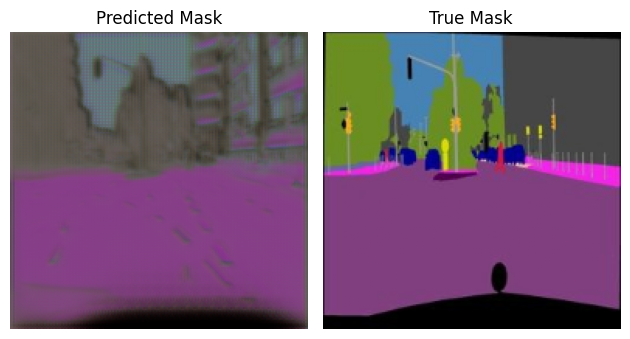

91/91 ━━━━━━━━━━━━━━━━━━━━ 1445s 16s/step - accuracy: 0.4315 - loss: 0.6559 - mean_io_u_1: 0.5000 - val_accuracy: 0.3977 - val_loss: 0.6049 - val_mean_io_u_1: 0.5000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


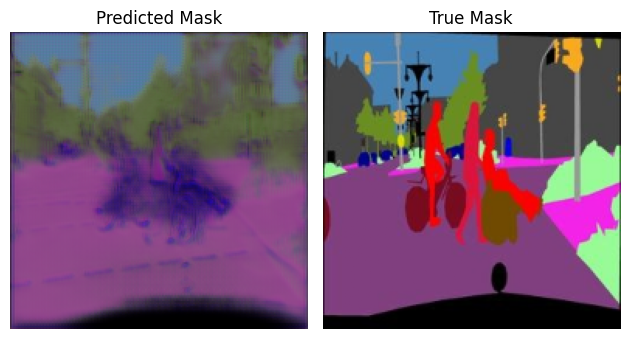

91/91 ━━━━━━━━━━━━━━━━━━━━ 1444s 16s/step - accuracy: 0.4355 - loss: 0.6098 - mean_io_u_1: 0.5000 - val_accuracy: 0.6279 - val_loss: 0.5886 - val_mean_io_u_1: 0.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


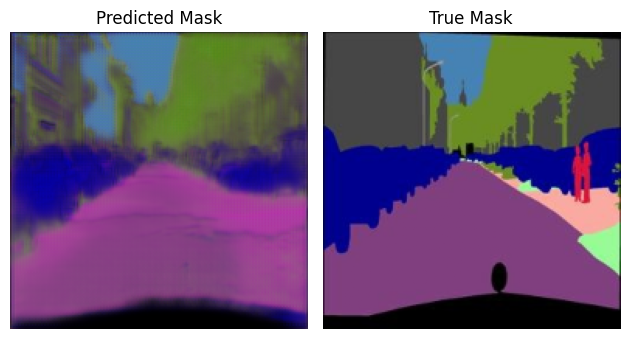

91/91 ━━━━━━━━━━━━━━━━━━━━ 1406s 15s/step - accuracy: 0.5354 - loss: 0.5931 - mean_io_u_1: 0.5000 - val_accuracy: 0.6778 - val_loss: 0.5760 - val_mean_io_u_1: 0.5000
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


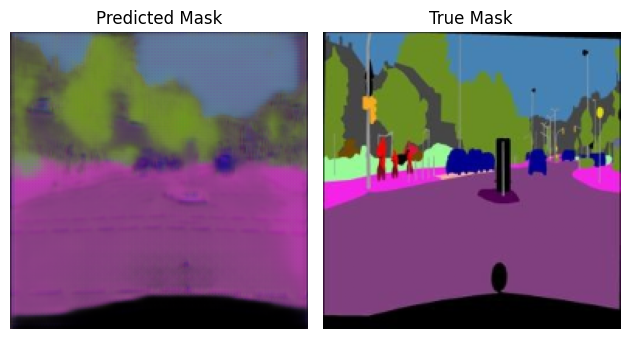

91/91 ━━━━━━━━━━━━━━━━━━━━ 1339s 14s/step - accuracy: 0.5832 - loss: 0.5833 - mean_io_u_1: 0.5000 - val_accuracy: 0.6954 - val_loss: 0.5655 - val_mean_io_u_1: 0.5000
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


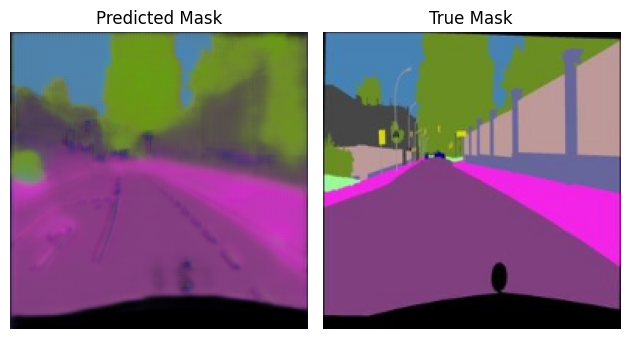

91/91 ━━━━━━━━━━━━━━━━━━━━ 1335s 14s/step - accuracy: 0.6268 - loss: 0.5795 - mean_io_u_1: 0.5000 - val_accuracy: 0.6980 - val_loss: 0.5626 - val_mean_io_u_1: 0.5000
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


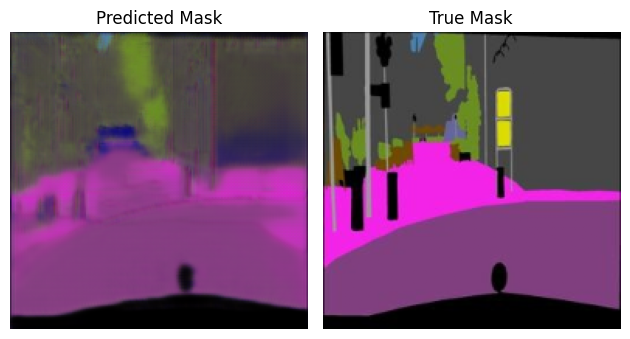

91/91 ━━━━━━━━━━━━━━━━━━━━ 1265s 14s/step - accuracy: 0.6686 - loss: 0.5752 - mean_io_u_1: 0.5000 - val_accuracy: 0.7282 - val_loss: 0.5606 - val_mean_io_u_1: 0.5000
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


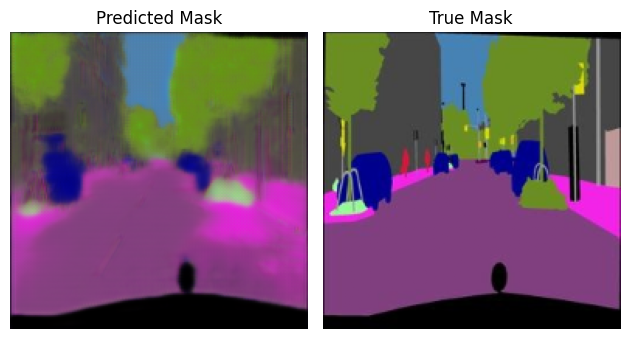

91/91 ━━━━━━━━━━━━━━━━━━━━ 1534s 17s/step - accuracy: 0.6859 - loss: 0.5710 - mean_io_u_1: 0.5000 - val_accuracy: 0.7424 - val_loss: 0.5547 - val_mean_io_u_1: 0.5000
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


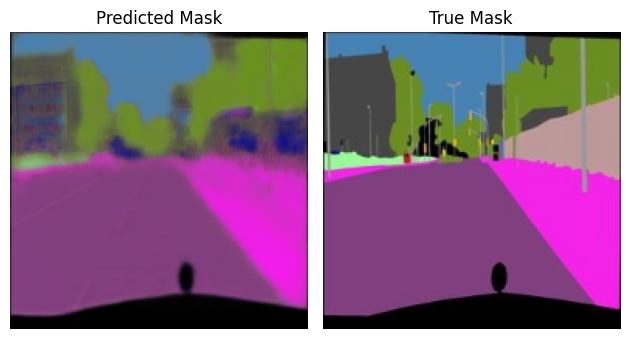

91/91 ━━━━━━━━━━━━━━━━━━━━ 1263s 14s/step - accuracy: 0.6971 - loss: 0.5686 - mean_io_u_1: 0.5000 - val_accuracy: 0.7358 - val_loss: 0.5541 - val_mean_io_u_1: 0.5000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


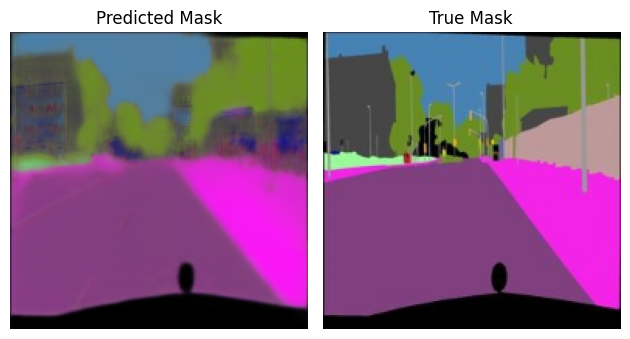

91/91 ━━━━━━━━━━━━━━━━━━━━ 1281s 14s/step - accuracy: 0.7005 - loss: 0.5674 - mean_io_u_1: 0.5000 - val_accuracy: 0.7267 - val_loss: 0.5519 - val_mean_io_u_1: 0.5000
Epoch 10/40
18/91 ━━━━━━━━━━━━━━━━━━━━ 16:42 14s/step - accuracy: 0.6830 - loss: 0.5661 - mean_io_u_1: 0.5000

In [ ]:
import numpy as np

# Convert X_train, y_train, X_valid, and y_valid to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

# Ensure that X_train and y_train have the same number of samples
if len(X_train) != len(y_train):
    raise ValueError("X_train and y_train must have the same number of samples.")

# Ensure that X_valid and y_valid have the same number of samples
if len(X_valid) != len(y_valid):
    raise ValueError("X_valid and y_valid must have the same number of samples.")

with tf.device('/GPU:0'):
    # Input Layer
    input_layer = Input(shape=X_train.shape[-3:])

    # Encoder
    p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
    p2, c2 = EncoderLayerBlock(32,0.1)(p1)
    p3, c3 = EncoderLayerBlock(64,0.2)(p2)
    p4, c4 = EncoderLayerBlock(128,0.2)(p3)

    # Encoding Layer
    c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)

    # Decoder
    d1 = DecoderLayerBlock(128,0.2)([c5, c4])
    d2 = DecoderLayerBlock(64,0.2)([d1, c3])
    d3 = DecoderLayerBlock(32,0.2)([d2, c2])
    d4 = DecoderLayerBlock(16,0.2)([d3, c1])

    # Output layer
    output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='sigmoid')(d4)

    # U-Net Model
    model = keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    # Compiling
    model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
)

    # Callbacks
    checkpoint_filepath = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/checkpoints/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_filepath)

# Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        ModelCheckpoint(filepath="/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/checkpoints/cp.ckpt.weights.h5", save_weights_only=True, save_best_only=True),
        ShowProgress()
    ]

    # Train The Model and Capture History
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=40,
        callbacks=callbacks
    )

## Saving the model

In [ ]:
model.save('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model')
model.save_weights('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model.h5')

# Evaluating the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Utilizing Model

First we should load the model

In [ ]:
# new_model = keras.models.load_model('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data')

# Improving the base model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

# ...

with tf.device('/GPU:0'):
    # Input Layer
    input_layer = Input(shape=X_train.shape[1:])

    # Encoder (EfficientNet-B7)
    encoder = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Encoding Layer
    x = encoder.output
    x = Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    c5 = x

    # Decoder
    d1 = DecoderLayerBlock(128, 0.2)([c5, encoder.get_layer('block6a_expand_activation').output])
    d2 = DecoderLayerBlock(64, 0.2)([d1, encoder.get_layer('block5c_expand_activation').output])
    d3 = DecoderLayerBlock(32, 0.2)([d2, encoder.get_layer('block4a_expand_activation').output])
    d4 = DecoderLayerBlock(16, 0.2)([d3, encoder.get_layer('block3b_expand_activation').output])
    d5 = DecoderLayerBlock(16, 0.2)([d4, input_layer])

    # Output layer
    output = Conv2D(3, kernel_size=1, strides=1, padding='same', activation='sigmoid')(d5)

    # U-Net++ Model
    model = keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    model.compile(
        loss=BinaryFocalCrossEntropy(),
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
    )

    # ...